# 不等流計算2:一般断面の不等流計算

## 課題1

ある河川断面の座標が次図のとおりとする。

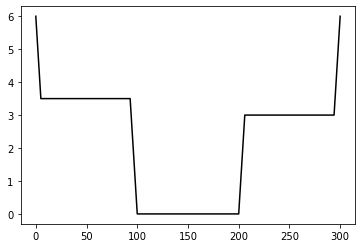

In [1]:
import matplotlib.pyplot as plt
x=[0, 5,93,100,200,206,294,300]
y=[6, 3.5, 3.5,  0,  0,  3,  3,  6]
plt.plot(x,y, c='k')
plt.show()                # 描画

また、粗度係数は次のとおりとする。（個数は測点間で定義するためi-1個）

In [2]:
n=[0.041, 0.041,0.030,0.030,0.030,0.040,0.040]

断面特性を計算するプログラムは次のように記述できる。

In [3]:
def H2ABSKn(x, y, n, H):
    A, B, S, SN = float(0), float(0), float(0), float(0)
    
    for i in range(1, len(x)):
        dx = x[i] - x[i-1]    
        dy = y[i] - y[i-1]    
        hb, hf = H - y[i-1], H - y[i]
        
        if hb <= float(0) :
            if hf > float(0) :
                dx_dh = dx / (hf - hb)
                B += hf * dx_dh
                A += 0.5 * hf * hf * dx_dh
                Sp = hf * np.sqrt( dx_dh * dx_dh + 1.0)
                S +=  Sp
                SN += Sp * n[i-1]**1.5
        elif hf <= float(0) :
            if hb > float(0) :
                dx_dh = dx / (hf - hb)
                B -= hb * dx_dh
                A -= 0.5 * hb * hb * dx_dh
                Sp = hb * np.sqrt(dx_dh * dx_dh + 1.0)
                S += Sp
                SN += Sp * n[i-1]**1.5
        else :
            B += dx
            A += 0.5 * dx * (hf + hb)
            Sp = np.sqrt(dx**2 + dy**2)
            S += Sp
            SN += Sp * n[i-1]**1.5
            
    if S <= float(0):
        nd = float(0)
        K = float(0)
    else:
        nd = (SN/S)**(2.0/3.0)
        K = A**(5.0/3.0)/nd/S**(2.0/3.0)
        
    return A, B, S, K, nd

- 水位が5.0の場合、各種断面諸元は次のとおりとなる。

In [4]:
import numpy as np
A, B, S, K, nd = H2ABSKn(np.array(x), np.array(y), np.array(n), 5.0)
print('河積：{}\n水面幅：{}\n潤辺：{}\n通水能：{}\n合成粗度係数：{}'.format(A, B, S, K, nd))

河積：858.0
水面幅：296.0
潤辺：298.3606797749979
通水能：47342.84520415623
合成粗度係数：0.03664910724429057


上記の横断座標、粗度係数、関数を用いて以下の2題についてプログラムを作成せよ。

1. 水位を0.01～6.0まで変化させて場合の以下の諸元の変化を図化せよ。
 - 河積（y軸：水位、x軸：河積）
 - 合成粗度係数（y軸：水位、x軸：合成粗度係数）
 - 通水能（y軸：水位、x軸：通水能）
1. 流量$1000 \mathrm{m^3/s}$、河床勾配$1/300$として等流水深時の水位を計算したいが、この条件では適切に水位を計算することができない。その理由を述べよ。余力があれば、この条件で安定的に等流水深時の水位を計算するプログラムを作成せよ。参考論文[石川ら：常流・射流が混在する区間の不等流計算法](https://cir.nii.ac.jp/crid/1522262179999678976)(webに無かったので添付しておきます．)

##  課題2：作業は不要です。中身を理解して下さい。

前出の断面座標、粗度係数を用いてモデル河道を作成する。
区間距離を200mとし、下流端からの距離、0.0～5.0kmは1/2000、5.0～10.0kmは1/1000、、10.0～15.0kmは1/500でy座標をスライドさせて各断面の座標を設定した。
なお、下流端断面の座標は前出の断面、粗度係数は全断面で一定とする。

各断面の断面座標、粗度係数、下流端からの距離のデータを次のとおりに作成した。

※各断面のデータを辞書形式{'x', 'y', 'n', 'L'}で示し、それを下流から順に並べたリストとしている。

In [5]:
import numpy as np

In [6]:
x=np.array([0, 5,93,100,200,206,294,300])
y=np.array([6, 3.5, 3.5,  0,  0,  3,  3,  6])
n=np.array([0.041, 0.041,0.030,0.030,0.030,0.040,0.040])

dx = 200
Ls = np.arange(0,15001,dx) 

sections = []
sect = {'x':x, 'y':y, 'n':n, 'L':Ls[0]}
sections.append(sect)

yold = y.copy()
for L in Ls[1:]:
    if L < 5000:
        ib = 1/2000
    elif L < 10000:
        ib = 1/1000
    else:
        ib = 1/500
        
    ynew = yold + dx*ib
    sect = {'x':x, 'y':ynew, 'n':n, 'L':L}
    sections.append(sect)
    yold = ynew.copy()

辞書形式は数値計算では扱いづらいためリスト形式としたいが、実河川ではx,y,nの個数が断面ごとに異なるため、単純なリスト形式にはできない。

そのため、x, y, n, Lをメンバ変数とするクラスを作成する。

In [7]:
class section(object):
    def __init__(self, x, y, n, L): #初期化のメソッド クラスを定義したときに動くメソッド
        self.x = x
        self.y = y
        self.n = n
        self.L = L

先程作成した断面データをクラスに格納する。

In [8]:
csections = [section(s['x'],s['y'],s['n'],s['L']) for s in sections]

In [9]:
print(csections[0].L, csections[-1].L)

0 15000


さらに、前出の断面諸元を計算する関数をクラスのメソッドとして追加すると、次のとおりとなる。

In [10]:
class section(object):
    def __init__(self, x, y, n, L):
        self.x = x
        self.y = y
        self.n = n
        self.L = L

    def H2ABSKn(self, H): #変更:引数は水位のみ
        A, B, S, SN = float(0), float(0), float(0), float(0)
        x = self.x #変更:メンバ変数を参照
        y = self.y #変更:メンバ変数を参照
        n = self.n #変更:メンバ変数を参照
        
        for i in range(1, len(x)):
            dx = x[i] - x[i-1]    
            dy = y[i] - y[i-1]    
            hb, hf = H - y[i-1], H - y[i]
            
            if hb <= float(0) :
                if hf > float(0) :
                    dx_dh = dx / (hf - hb)
                    B += hf * dx_dh
                    A += 0.5 * hf * hf * dx_dh
                    Sp = hf * np.sqrt( dx_dh * dx_dh + 1.0)
                    S +=  Sp
                    SN += Sp * n[i-1]**1.5
            elif hf <= float(0) :
                if hb > float(0) :
                    dx_dh = dx / (hf - hb)
                    B -= hb * dx_dh
                    A -= 0.5 * hb * hb * dx_dh
                    Sp = hb * np.sqrt(dx_dh * dx_dh + 1.0)
                    S += Sp
                    SN += Sp * n[i-1]**1.5
            else :
                B += dx
                A += 0.5 * dx * (hf + hb)
                Sp = np.sqrt(dx**2 + dy**2)
                S += Sp
                SN += Sp * n[i-1]**1.5
                
        if S <= float(0):
            nd = float(0)
            K = float(0)
        else:
            nd = (SN/S)**(2.0/3.0)
            K = A**(5.0/3.0)/nd/S**(2.0/3.0)
            
        return A, B, S, K, nd

全断面の最深河床高+5mの水位のときの合成粗度係数を求めるプログラムは以下のように書ける。

以上、今後は講義では、このクラスに機能を追加していくため、クラスの仕組みを理解しておくこと。よくわからない方は丸暗記でO.K.です。

In [11]:
csections = [section(s['x'],s['y'],s['n'],s['L']) for s in sections]

for s in csections:
    A,B,S,K,n = s.H2ABSKn(s.y.min() + 5) # 引数は水位のみ
    print(s.L, n)

0 0.03664910724429057
200 0.03664910724429057
400 0.03664910724429057
600 0.03664910724429057
800 0.03664910724429057
1000 0.03664910724429057
1200 0.03664910724429057
1400 0.03664910724429057
1600 0.03664910724429057
1800 0.03664910724429057
2000 0.03664910724429057
2200 0.03664910724429057
2400 0.03664910724429057
2600 0.03664910724429057
2800 0.03664910724429056
3000 0.03664910724429056
3200 0.03664910724429056
3400 0.03664910724429056
3600 0.03664910724429056
3800 0.03664910724429056
4000 0.03664910724429056
4200 0.03664910724429056
4400 0.03664910724429056
4600 0.03664910724429056
4800 0.03664910724429056
5000 0.03664910724429057
5200 0.03664910724429057
5400 0.036649107244290574
5600 0.03664910724429057
5800 0.036649107244290574
6000 0.036649107244290574
6200 0.036649107244290574
6400 0.036649107244290574
6600 0.036649107244290574
6800 0.036649107244290574
7000 0.036649107244290574
7200 0.036649107244290574
7400 0.036649107244290574
7600 0.036649107244290574
7800 0.03664910724429

## 課題3：

 1. 課題2で定義したクラスに限界水深（限界流時の水位）を計算するメソッドを追加せよ．
 1. 課題2で定義したクラスを用いて，不等流計算モデルを作成し，縦断水位を計算せよ．計算条件は，流量：$1500\rm{m^3/s}$，下流端水位：等流水深（等流時水位）とする．